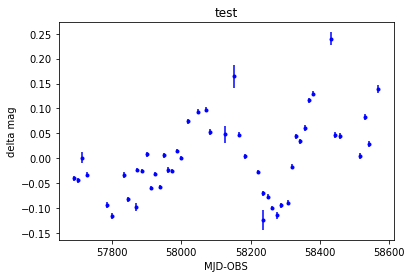

In [9]:
 # 15-Sep-2019
# Bo Milvang-Jensen
# Very rudimentary script to read+plot ...

import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
import emcee
import george
from george import kernels

# Read photometry catalogue created by my other script
photfilename = 'F51_out_REMIR_ROS2.fits'
data = fits.getdata(photfilename, 1)

# The photometry catalogue contains aperture photometry in 25 different
# apertures. If we number them 0..24, they correspond to diameters 1..25 arcsec
apno = 10 # This is then 11 arcsec

# The photometry catalogue contains photometry for the AGN plus some more
# objects in the field, in this case the AGN + 6 more objetcs, so 7 in
# total. The AGN is number 1, and the others 2, 3, etc.
# This is seen in the column names, which end in _1, _2, etc.
# E.g. the column MAG_APER_1 contains the aperture magnitudes (for all
# 25 apertures) for the AGN.

# Get the aperture magnitudes
##foo = data['MAG_APER_1'] # has shape e.g. (767, 25), the 25 being the apertures
mag_agn  = data['MAG_APER_1'][:,apno]
mag_ref1 = data['MAG_APER_3'][:,apno] # I have found that _3 is good here
mag_ref2 = data['MAG_APER_4'][:,apno]

# Get the differential magnitudes
delta_mag_agn_ref1 = mag_agn - mag_ref1
delta_mag_ref2_ref1 = mag_ref2 - mag_ref1

# Get the magnitude errors 
magerr_agn = data['MAGERR_APER_1'][:,apno]
magerr_ref1 = data['MAGERR_APER_3'][:,apno]
magerr_ref2= data['MAGERR_APER_4'][:,apno]

# TODO Here I could loop over the filters, subtracting the median

# For simplicity "extract" some arrays from the data
filt = data['filter']
mjd_obs = data['mjd_obs']

# A simple plot of the J band differential mags, with the median subtracted
# Do 'H' and 'K' in the same way
maskJ = (filt == 'J')
#print(magerr_ref1[mask])
#plt.scatter(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]))
plt.errorbar(mjd_obs[maskJ], delta_mag_agn_ref1[maskJ]-np.median(delta_mag_agn_ref1[maskJ]), magerr_ref1[maskJ],fmt='b.')
plt.title('test')
plt.xlabel('MJD-OBS')
plt.ylabel('delta mag')
plt.show()

In [3]:
#J band data
xJ=np.asarray(mjd_obs[maskJ], dtype=float)
nJ=len(xJ)
XJ = np.reshape(xJ,(nJ,1))
yJ=np.asarray(delta_mag_agn_ref1[maskJ]-np.median(delta_mag_agn_ref1[maskJ]), dtype=float)
yJerr = np.array(magerr_ref1[maskJ], dtype=float)

#H band data
maskH = (filt == 'H')

xHtemp=np.asarray(mjd_obs[maskH], dtype=float)
xH=np.delete(xHtemp,(1,2))
nH=len(xH)
XH = np.reshape(xH,(nH,1))
XH_new=np.linspace(min(XH),max(XH),100,dtype=np.float64)

Hdelta_mag_agn_ref1=np.delete(delta_mag_agn_ref1[maskH],(1,2))
yH=np.asarray(Hdelta_mag_agn_ref1-np.median(Hdelta_mag_agn_ref1), dtype=float)
yHerrtemp = np.asarray(magerr_ref1[maskH], dtype=float)
yHerr=np.delete(yHerrtemp,(1,2))

#K band data
maskK = (filt == 'K')
xK=np.asarray(mjd_obs[maskK], dtype=float)
nK=len(xK)
XK = np.reshape(xK,(nK,1))
yK=np.asarray(delta_mag_agn_ref1[maskK]-np.median(delta_mag_agn_ref1[maskK]), dtype=float)
yKerr = np.asarray(magerr_ref1[maskK], dtype=float)

#time array with all bands
#be carefull with how XJ and xj acts 
X_tot= np.concatenate((xJ,xH,xK),axis=None)
X_tot=np.reshape(X_tot,(len(X_tot),1))

#combine all y values for guess
Y_tot= np.concatenate((yJ,yH,yK),axis=None)
Y_tot=np.reshape(Y_tot,(len(Y_tot),1))

#time delay array
ntau=299
tau=np.linspace(0.0,299.0,ntau)

In [ ]:
#Different wavelength for different bands, not a free paramter 
#REMIR filters in nm NEED DATASHEET
Jwav=1250.0 

#Define constants 
wav_0 = 1122.4#Reference wavelength in nm, use 500?
h = 6.626e-34#Plancks constant in J*s
c = 299792458.0#speed of light in m/s
k = 1.38e-23#Boltzmanns constant in J/K
    
#peak Black Body from uniform torus temperature
wav_peak = 2.898*10**6/T
b_max = h*c/(1e-9*wav_peak*k*T)
BB_max = 1.0/( (wav_peak**5) * (np.exp(b_max) - 1.0) )
    
#Universal lognormal for Dusty Torus 
exp_DT = -((np.log((tau-theta_DT)/m_DT))**2/(2*sigma_DT**2)) 
front_DT = 1.0/((tau-theta_DT)*sigma_DT*np.sqrt(2*np.pi))
lognorm_DT = front_DT*np.exp(exp_DT)
where_are_NaNs1 = np.isnan(lognorm_DT)
lognorm_DT[where_are_NaNs1] = 0.0
    
#Dusty Torus transfer equation for J band
Jb = h*c/(1e-9*Jwav*k*T)
JBB = (1.0/( Jwav**5 * (np.exp(Jb) - 1.0) ))/BB_max
JPsi_DT = JBB*lognorm_DT
    
#Accretion Disk transfer equation for the J band
Jpowr = K_0*(Jwav/wav_0)**(index)    
Jexp_AD = -((np.log((tau-Jtheta_AD)/Jm_AD))**2/(2*Jsigma_AD**2))
Jfront_AD = 1.0/((tau-Jtheta_AD)*Jsigma_AD*np.sqrt(2*np.pi))
Jlognorm_AD = Jfront_AD*np.exp(Jexp_AD)
where_are_NaNs2 = np.isnan(Jlognorm_AD)
Jlognorm_AD[where_are_NaNs2] = 0.0
JPsi_AD = Jpowr*Jlognorm_AD

#Full transfer equations
Jtransfer = JPsi_DT + JPsi_AD

In [10]:
def log_likelihood(theta, x, y, yerr):
    sigma_DT, Jsigma_AD, mu_DT, Jmu_AD, theta_DT, Jtheta_AD, T, Jwav, wav_0, K_0, index, η, ℓ= theta
    
    
    gp=george.GP(η**2*kernels(Expkernel(ℓ)))
    
    
    h = 6.626e-34#Plancks constant in units of [m^2*kg/s]
    c = 299792458.0#speed of light in units of [m/s]
    k = 1.38e-23#Boltzmanns constant in units of [m^2*kg/s^2*K]
    wav_0 = 1122.4#Reference wavelength in nm, use 500?
    T=np.exp(T)#go from log value to linear value 
    
    #peak Black Body from uniform torus temperature
    wav_peak = 2.898*10**6/T
    b_max = h*c/(1e-9*wav_peak*k*T)
    BB_max = 1.0/( (wav_peak**5) * (np.exp(b_max) - 1.0) )
    
    #Universal lognormal for Dusty Torus 
    exp_DT = -((np.log((tau-theta_DT)/m_DT))**2/(2*sigma_DT**2)) 
    front_DT = 1.0/((tau-theta_DT)*sigma_DT*np.sqrt(2*np.pi))
    lognorm_DT = front_DT*np.exp(exp_DT)
    where_are_NaNs1 = np.isnan(lognorm_DT)
    lognorm_DT[where_are_NaNs1] = 0.0
    
    #Dusty Torus transfer equation for J band
    Jb = h*c/(1e-9*Jwav*k*T)
    JBB = (1.0/( Jwav**5 * (np.exp(Jb) - 1.0) ))/BB_max
    JPsi_DT = JBB*lognorm_DT
    
    #Accretion Disk transfer equation for the J band
    Jpowr = K_0*(Jwav/wav_0)**(index)    
    Jexp_AD = -((np.log((tau-Jtheta_AD)/Jm_AD))**2/(2*Jsigma_AD**2))
    Jfront_AD = 1.0/((tau-Jtheta_AD)*Jsigma_AD*np.sqrt(2*np.pi))
    Jlognorm_AD = Jfront_AD*np.exp(Jexp_AD)
    where_are_NaNs2 = np.isnan(Jlognorm_AD)
    Jlognorm_AD[where_are_NaNs2] = 0.0
    JPsi_AD = Jpowr*Jlognorm_AD
    
    #Full transfer equations
    Jtransfer = JPsi_DT + JPsi_AD
    
    model = np.convolve(transfer, gp, 'same')
    
    return -0.5*np.sum(((y-model)/yerr)**2+ np.log(yerr*np.sqrt(2*np.pi)))